In [102]:
import os
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import shutil
import random
import string
import gzip
import json
import numpy as np
def path_replace(path, old, new):
    return Path(str(path).replace(str(old), str(new)))
def crop_and_resize(img, target_size, mode="center"):
    """Crop to square and resize to target_size
    mode:
      center: center crop
      left: keep left or top most pixels
      right: keep right or bottom most pixels
      random: random crop
    """
    crop_size = min(img.size)
    width, height = img.size
    if width==target_size and height==target_size:
        return img
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    if mode == "center":
        img = img.crop((left, top, right, bottom))
    elif mode == "left":
        img = img.crop((0, 0, right-left, bottom-top))
    elif mode == "right":
        img = img.crop((width-right+left, height-bottom+top, width, height))
    elif mode == "random":
        left_r = random.randint(0, width-right+left)
        top_r = random.randint(0, height-bottom+top)
        img = img.crop((left_r, top_r, left_r+right-left, top_r+bottom-top))
    else:
        raise AssertionError("Wrong mode")
    img = img.resize((target_size, target_size),resample=Image.Resampling.LANCZOS)
    return img
def random_string(n):
    return ''.join(random.sample(string.ascii_letters + string.digits, n))
def check_func(a, b):
    return str(a).replace("/rgb/","/depth/").replace(".jpg",".png")==str(b)

# DIODE RGBD

25458 train, 771 val

In [20]:
# train split
FOLDER_RGB_IN = Path("/root/autodl-tmp/diode_clean_resize/train/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/diode_clean_resize/train/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-diode/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-diode/train")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = list(FOLDER_RGB_IN.glob("*/*/rgb/*.png"))
depth_files = list(FOLDER_DEPTH_IN.glob("*/*/depth/*.png"))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    rgb = Image.open(rgb_files[i])
    rgb.save(rgb_path)
    shutil.copy(depth_files[i], depth_path)

  0%|          | 0/25458 [00:00<?, ?it/s]

In [21]:
# val split
FOLDER_RGB_IN = Path("/root/autodl-tmp/diode_clean_resize/val/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/diode_clean_resize/val/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-diode/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-diode/val")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = list(FOLDER_RGB_IN.glob("*/*/rgb/*.png"))
depth_files = list(FOLDER_DEPTH_IN.glob("*/*/depth/*.png"))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    rgb = Image.open(rgb_files[i])
    rgb.save(rgb_path)
    shutil.copy(depth_files[i], depth_path)

  0%|          | 0/771 [00:00<?, ?it/s]

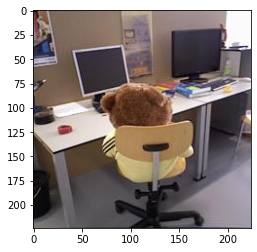

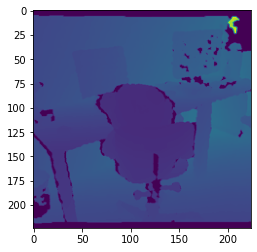

In [58]:
# check
rgb_files = list(FOLDER_RGB_OUT.glob("*.jpg"))
depth_files = list(FOLDER_DEPTH_OUT.glob("*.png"))
assert len(rgb_files)==len(depth_files)
idx = random.randint(0, len(rgb_files)-1)
rgb = Image.open(rgb_files[idx])
depth = Image.open(depth_files[idx])
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(np.array(depth).astype(float))

# NYUv2 RGBD
1300 train, 149 val

In [32]:
# train split
FOLDER_RGB_IN = Path("/root/autodl-tmp/nyuv2_resize/train/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/nyuv2_resize/train/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-nyuv2/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-nyuv2/train")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = list(FOLDER_RGB_IN.glob("*/rgb/*.png"))
depth_files = list(FOLDER_DEPTH_IN.glob("*/depth/*.png"))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    rgb = Image.open(rgb_files[i])
    rgb.save(rgb_path)
    shutil.copy(depth_files[i], depth_path)

  0%|          | 0/1300 [00:00<?, ?it/s]

In [33]:
# val split
FOLDER_RGB_IN = Path("/root/autodl-tmp/nyuv2_resize/val/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/nyuv2_resize/val/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-nyuv2/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-nyuv2/val")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = list(FOLDER_RGB_IN.glob("*/rgb/*.png"))
depth_files = list(FOLDER_DEPTH_IN.glob("*/depth/*.png"))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    rgb = Image.open(rgb_files[i])
    rgb.save(rgb_path)
    shutil.copy(depth_files[i], depth_path)

  0%|          | 0/149 [00:00<?, ?it/s]

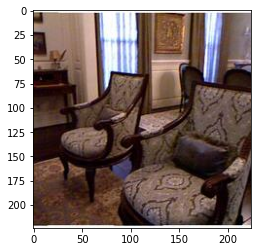

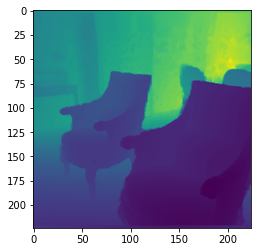

In [41]:
# check
rgb_files = list(FOLDER_RGB_OUT.glob("*.jpg"))
depth_files = list(FOLDER_DEPTH_OUT.glob("*.png"))
assert len(rgb_files)==len(depth_files)
idx = random.randint(0, len(rgb_files)-1)
rgb = Image.open(rgb_files[idx])
depth = Image.open(depth_files[idx])
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(np.array(depth).astype(float))

# TUM RGBD
110266 train, 19558 val

In [47]:
# train split
FOLDER_RGB_IN = Path("/root/autodl-tmp/tumrgbd_clean_resize/train/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/tumrgbd_clean_resize/train/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-tum/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-tum/train")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = list(FOLDER_RGB_IN.glob("*/rgb/*.png"))
depth_files = list(FOLDER_DEPTH_IN.glob("*/depth/*.png"))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    rgb = Image.open(rgb_files[i])
    rgb.save(rgb_path)
    depth = Image.open(depth_files[i])
    depth = (np.array(depth)*0.2).astype(np.uint16)
    depth = Image.fromarray(depth)
    depth.save(depth_path)

  0%|          | 0/110266 [00:00<?, ?it/s]

In [48]:
# val split
# /root/autodl-tmp/stage2/depth-tum/val/19557.png
FOLDER_RGB_IN = Path("/root/autodl-tmp/tumrgbd_clean_resize/val/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/tumrgbd_clean_resize/val/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-tum/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-tum/val")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = list(FOLDER_RGB_IN.glob("*/rgb/*.png"))
depth_files = list(FOLDER_DEPTH_IN.glob("*/depth/*.png"))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    rgb = Image.open(rgb_files[i])
    rgb.save(rgb_path)
    depth = Image.open(depth_files[i])
    depth = (np.array(depth)*0.2).astype(np.uint16)
    depth = Image.fromarray(depth)
    depth.save(depth_path)

  0%|          | 0/19558 [00:00<?, ?it/s]

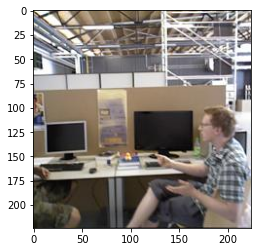

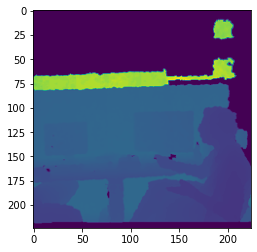

In [56]:
# check
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-tum/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-tum/val")
rgb_files = list(FOLDER_RGB_OUT.glob("*.jpg"))
depth_files = list(FOLDER_DEPTH_OUT.glob("*.png"))
assert len(rgb_files)==len(depth_files)
idx = random.randint(0, len(rgb_files)-1)
rgb = Image.open(rgb_files[idx])
depth = Image.open(depth_files[idx])
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(np.array(depth).astype(float))

# SUN3D RGBD

2407496 train, 170582 val

In [157]:
# train split
FOLDER_RGB_IN = Path("/root/autodl-tmp/sun3d/train/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/sun3d/train/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-sun3d/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-sun3d/train")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = sorted(list(FOLDER_RGB_IN.glob("*/rgb/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_IN.glob("*/depth/*.png")))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    assert check_func(rgb_files[i], depth_files[i])
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    shutil.copy(rgb_files[i], rgb_path)
    depth = Image.open(depth_files[i])
    depth = (np.array(depth)/8).astype(np.uint16) # shift 3 bits back
    depth = Image.fromarray(depth)
    depth.save(depth_path)

  0%|          | 0/2407496 [00:00<?, ?it/s]

In [158]:
# val split
FOLDER_RGB_IN = Path("/root/autodl-tmp/sun3d/val/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/sun3d/val/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-sun3d/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-sun3d/val")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = sorted(list(FOLDER_RGB_IN.glob("*/rgb/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_IN.glob("*/depth/*.png")))
assert len(rgb_files)==len(depth_files)
N = len(rgb_files)
for i in tqdm(range(N)):
    assert check_func(rgb_files[i], depth_files[i])
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    shutil.copy(rgb_files[i], rgb_path)
    depth = Image.open(depth_files[i])
    depth = (np.array(depth)/8).astype(np.uint16) # shift 3 bits back
    depth = Image.fromarray(depth)
    depth.save(depth_path)

  0%|          | 0/170582 [00:00<?, ?it/s]

3228


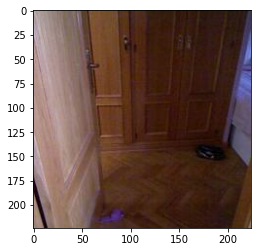

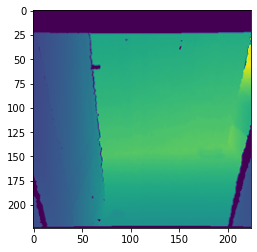

In [161]:
# check
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-sun3d/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-sun3d/val")
rgb_files = list(FOLDER_RGB_OUT.glob("*.jpg"))
depth_files = list(FOLDER_DEPTH_OUT.glob("*.png"))
assert len(rgb_files)==len(depth_files)
idx = random.randint(0, len(rgb_files)-1)
rgb = Image.open(rgb_files[idx])
depth = Image.open(depth_files[idx])
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(np.array(depth).astype(float))
print(np.array(depth).max())

# Scenenet

2529750 train, 150000 val

In [114]:
# train split
FOLDER_RGB_IN = Path("/root/autodl-tmp/scenenet/scenenet_resize/train/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/scenenet/scenenet_resize/train/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-scenenet/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-scenenet/train")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = sorted(list(FOLDER_RGB_IN.glob("*/*/rgb/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_IN.glob("*/*/depth/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
rgb_files = rgb_files[:2529750]
depth_files = depth_files[:2529750]
N = len(rgb_files)
for i in tqdm(range(N)):
    assert check_func(rgb_files[i], depth_files[i])
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    shutil.copy(rgb_files[i], rgb_path)
    shutil.copy(depth_files[i], depth_path)

5059500


  0%|          | 0/2529750 [00:00<?, ?it/s]

In [103]:
# val split
FOLDER_RGB_IN = Path("/root/autodl-tmp/scenenet/scenenet_resize/val/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/scenenet/scenenet_resize/val/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-scenenet/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-scenenet/val")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = sorted(list(FOLDER_RGB_IN.glob("*/*/rgb/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_IN.glob("*/*/depth/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
rgb_files = rgb_files[:150000]
depth_files = depth_files[:150000]
N = len(rgb_files)
for i in tqdm(range(N)):
    assert check_func(rgb_files[i], depth_files[i])
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    shutil.copy(rgb_files[i], rgb_path)
    shutil.copy(depth_files[i], depth_path)

300000


  0%|          | 0/150000 [00:00<?, ?it/s]

/root/autodl-tmp/stage2/rgb-scenenet/train/1761256.jpg /root/autodl-tmp/stage2/depth-scenenet/train/1761256.png
12166


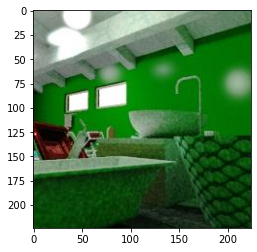

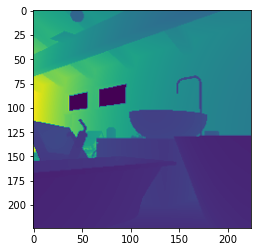

In [145]:
# check
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-scenenet/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-scenenet/train")
rgb_files = list(FOLDER_RGB_OUT.glob("*.jpg"))
depth_files = list(FOLDER_DEPTH_OUT.glob("*.png"))
assert len(rgb_files)==len(depth_files)
print(len(rgb_files))
idx = random.randint(0, len(rgb_files)-1)
rgb = Image.open(rgb_files[idx])
depth = Image.open(depth_files[idx])
print(rgb_files[idx], depth_files[idx])
plt.figure()
plt.imshow(rgb)
plt.figure()
plt.imshow(np.array(depth).astype(float))
print(np.array(depth).max())

# HM3D


In [148]:
# train split
FOLDER_RGB_IN = Path("/root/autodl-tmp/hm3d/train/")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/hm3d/train/")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-hm3d/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-hm3d/train")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = sorted(list(FOLDER_RGB_IN.glob("*/*/rgb/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_IN.glob("*/*/depth/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
rgb_files = rgb_files
depth_files = depth_files
N = len(rgb_files)
for i in tqdm(range(N)):
    assert check_func(rgb_files[i], depth_files[i])
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    shutil.copy(rgb_files[i], rgb_path)
    shutil.copy(depth_files[i], depth_path)

3105845


  0%|          | 0/3105845 [00:00<?, ?it/s]

In [149]:
# val split
FOLDER_RGB_IN = Path("/root/autodl-tmp/hm3d/pretrain_val/hm3d_val")
FOLDER_DEPTH_IN = Path("/root/autodl-tmp/hm3d/pretrain_val/hm3d_val")

FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-hm3d/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-hm3d/val")
os.makedirs(FOLDER_RGB_OUT,exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT,exist_ok=True)

rgb_files = sorted(list(FOLDER_RGB_IN.glob("*/rgb/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_IN.glob("*/depth/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
rgb_files = rgb_files
depth_files = depth_files
N = len(rgb_files)
for i in tqdm(range(N)):
    assert check_func(rgb_files[i], depth_files[i])
    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(i)
    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(i)
    shutil.copy(rgb_files[i], rgb_path)
    shutil.copy(depth_files[i], depth_path)

156040


  0%|          | 0/156040 [00:00<?, ?it/s]

In [ ]:
# check
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/rgb-hm3d/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/depth-hm3d/train")
rgb_files = list(FOLDER_RGB_OUT.glob("*.jpg"))
depth_files = list(FOLDER_DEPTH_OUT.glob("*.png"))
assert len(rgb_files)==len(depth_files)
print(len(rgb_files))
for _ in range(20):
    idx = random.randint(0, len(rgb_files)-1)
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    print(np.array(depth).max())

# C4 text and sub

7126345 train text, 45576 val text

In [2]:
from nltk.tokenize import sent_tokenize
# train split
FOLDER_IN = Path("/root/autodl-tmp/c4/en")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-c4/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-c4/train")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
START = 100
END =  120
files = sorted(list(FOLDER_IN.glob("c4-train*.json.gz")))
cnt = 0
for i in tqdm(range(START,END)):
    with gzip.open(files[i], "r") as f:
        for line in f.readlines():
            text = json.loads(line)["text"].replace("\n"," ").strip()
            inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
            with open(inst_path, "w") as f:
                f.write(text)
            sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
            with open(sub_path, "w") as f:
                f.write("\n".join(sent_tokenize(text)))
            cnt += 1
print(cnt)

  0%|          | 0/20 [00:00<?, ?it/s]

7126345


In [5]:
# validation split
FOLDER_IN = Path("/root/autodl-tmp/c4/en")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-c4/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-c4/val")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
START = 2
END =  3
files = sorted(list(FOLDER_IN.glob("c4-val*.json.gz")))
cnt = 0
for i in tqdm(range(START,END)):
    with gzip.open(files[i], "r") as f:
        for line in f.readlines():
            text = json.loads(line)["text"].replace("\n"," ").strip()
            inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
            with open(inst_path, "w") as f:
                f.write(text)
            sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
            with open(sub_path, "w") as f:
                f.write("\n".join(sent_tokenize(text)))
            cnt += 1
print(cnt)

  0%|          | 0/1 [00:00<?, ?it/s]

45576


In [6]:
# check
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-c4/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(files[0])
with open(files[4], "r") as f:
    print(f.read())

/root/autodl-tmp/stage2/sub-c4/val/00000000.txt
This was the very first recipe I ever made by myself.
I was about 11 years old.
Yes I have been cooking pretty much my whole life, remember this picture?
You can read about it here.
Anyways, I was an interesting child.
Normal children ask for toys for Christmas.
Not me.
I asked for a Mixer.
Yeah, like a kitchen aid.
And no, I didn't actually get a Kitchen Aid, I got a cheap knock-off.
But I didn't care.
I was thrilled about my new mixer, and ended up making these cookies to test it out!
I grew up eating these cookies, especially during Christmas time.
They are basically a shortbread cookie, and they are delicious!
I actually made this dough a while back and froze some cookie dough to see if they would turn out.
It turns out that it freezes great, and I just had to cook them a little bit longer and they were just as delicious!
PS: I still don't own a Kitchen Aid mixer.
These are my all time favorite cookie!
They're a must on our Christmas 

# Marky-mT5 gibson
https://github.com/google-research-datasets/RxR/blob/main/marky-mT5/README.md

1018368 train

41736 val

In [72]:
import gzip
import jsonlines
raw_instructions = []
with jsonlines.open("/root/autodl-tmp/marky/rxr_marky_gibson_en_train_guide.jsonl") as reader:
    for obj in reader:
        raw_instructions.append(obj["instruction"])

# train split
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-marky/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-marky/train")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
for text in raw_instructions[:1018368]:
    inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
    with open(inst_path, "w") as f:
        f.write(text)
    sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
    with open(sub_path, "w") as f:
        subs = sent_tokenize(text)
        if len(subs)==1:
            subs = [v.strip()+"." for v in text.split(",")]
        f.write("\n".join(subs))
    cnt += 1

# val split
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-marky/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-marky/val")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
for text in raw_instructions[1018368:]:
    inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
    with open(inst_path, "w") as f:
        f.write(text)
    sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
    with open(sub_path, "w") as f:
        subs = sent_tokenize(text)
        if len(subs)==1:
            subs = [v.strip()+"." for v in text.split(",")]
            subs = [v.replace("..", ".") for v in subs]
        f.write("\n".join(subs))
    cnt += 1

# check
FOLDER_OUT = Path("/root/autodl-tmp/stage2/text-marky/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-marky/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-marky/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())

1018368
You are in a empty room facing towards the wall near the window, take a right turn and go straight to the wall, turn around and go straight to the bathtub, and take slightly left turn and go straight to the bed near the night lamp, turn around and go straight to the wardrobe, take slightly right turn and go straight, take a left turn and go straight near the plant pot, take a left turn and go straight to the railing and the railing, and go straight to the staircase, and go down the stairs, take a left turn and go straight near the staircase, take slightly left turn and go straight to the staircase. This is the endpoint.
1018368
You are in a empty room facing towards the wall near the window, take a right turn and go straight to the wall, turn around and go straight to the bathtub, and take slightly left turn and go straight to the bed near the night lamp, turn around and go straight to the wardrobe, take slightly right turn and go straight, take a left turn and go straight near

# Text old version, Touchdown, map2seq, CHALET, ALFRED

+ Touchdown: 6525 train, 1391 val
+ map2seq: 5667 train, 605 val
+ CHALET: 3000 train, 642 val
+ ALFRED: 21025 train, 1641 val

In [30]:
from nltk.tokenize import sent_tokenize
# Touchdown
# train split
FOLDER_IN = Path("/root/autodl-tmp/touchdown")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-touchdown/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-touchdown/train")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
data = []
with open(FOLDER_IN/"train.json", "r") as f:
    for line in f.readlines():
            data.append(json.loads(line))
    for v in data:
        text = v["navigation_text"].strip()
        inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
        with open(inst_path, "w") as f:
            f.write(text)
        sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
        with open(sub_path, "w") as f:
            f.write("\n".join(sent_tokenize(text)))
        cnt += 1

# val split
FOLDER_IN = Path("/root/autodl-tmp/touchdown")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-touchdown/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-touchdown/val")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
data = []
with open(FOLDER_IN/"dev.json", "r") as f:
    for line in f.readlines():
            data.append(json.loads(line))
    for v in data:
        text = v["navigation_text"].strip()
        inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
        with open(inst_path, "w") as f:
            f.write(text)
        sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
        with open(sub_path, "w") as f:
            f.write("\n".join(sent_tokenize(text)))
        cnt += 1

# check
FOLDER_OUT = Path("/root/autodl-tmp/stage2/text-touchdown/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-touchdown/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())

6525
Turn so you are moving against the flow of traffic. You will only move about half way down the block (against traffic). On the right side there will be black awning sticking out over the side walk. It will have white numbers on it.
1391
Go in the same direction as traffic.
Move forward to the first intersection.
Turn left.
You will be going with the flow of traffic.
Stop shortly before the intersection, before you even reach the first crosswalk.


In [29]:
# map2seq
# train split
FOLDER_IN = Path("/root/autodl-tmp/map2seq/splits")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-map2seq/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-map2seq/train")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
data = []
with open(FOLDER_IN/"train.json", "r") as f:
    data = json.loads(f.read())
    for v in data:
        text = v["instructions"].strip()
        inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
        with open(inst_path, "w") as f:
            f.write(text)
        sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
        with open(sub_path, "w") as f:
            f.write("\n".join(sent_tokenize(text)))
        cnt += 1

# val split
FOLDER_IN = Path("/root/autodl-tmp/map2seq/splits")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-map2seq/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-map2seq/val")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
data = []
with open(FOLDER_IN/"val.json", "r") as f:
    data = json.loads(f.read())
    for v in data:
        text = v["instructions"].strip()
        inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
        with open(inst_path, "w") as f:
            f.write(text)
        sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
        with open(sub_path, "w") as f:
            f.write("\n".join(sent_tokenize(text)))
        cnt += 1

# check
FOLDER_OUT = Path("/root/autodl-tmp/stage2/text-map2seq/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-map2seq/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())

5667
Pass the playground on the right and turn left at the lights. Pass Domino's on the right and turn left at the lights. Pass another playground on the right and go through the lights. Turn right at the following corner. Pass church on the right and turn left at the end of the block. Take a step and stop.
5667
Pass the playground on the right and turn left at the lights.
Pass Domino's on the right and turn left at the lights.
Pass another playground on the right and go through the lights.
Turn right at the following corner.
Pass church on the right and turn left at the end of the block.
Take a step and stop.


In [59]:
# CHALET
import pandas as pd
FOLDER_IN = "/root/autodl-tmp/chalet/text2traj_instructions_2018_emnlp_instructions.csv"
df = pd.read_csv(FOLDER_IN)
raw_instructions = []
for i, sample in df.iterrows():
    if "\r\n" in sample["inst1"]:
        if "." in sample["inst1"]:
            raw_instructions.append(sample["inst1"].replace("\r\n", " ").replace("..", "."))
        else:
            raw_instructions.append(sample["inst1"].replace("\r\n", ". ").replace("..", "."))
    else:
        raw_instructions.append(sample["inst1"])

    if "\r\n" in sample["inst2"]:
        if "." in sample["inst2"]:
            raw_instructions.append(sample["inst2"].replace("\r\n", " ").replace("..", "."))
        else:
            raw_instructions.append(sample["inst2"].replace("\r\n", ". ").replace("..", "."))
    else:
        raw_instructions.append(sample["inst2"])

# train split
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-chalet/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-chalet/train")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
for text in raw_instructions[:3000]:
    inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
    with open(inst_path, "w") as f:
        f.write(text)
    sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
    with open(sub_path, "w") as f:
        f.write("\n".join(sent_tokenize(text)))
    cnt += 1

# val split
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-chalet/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-chalet/val")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
for text in raw_instructions[3000:]:
    inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
    with open(inst_path, "w") as f:
        f.write(text)
    sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
    with open(sub_path, "w") as f:
        f.write("\n".join(sent_tokenize(text)))
    cnt += 1

# check
FOLDER_OUT = Path("/root/autodl-tmp/stage2/text-chalet/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[5], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-chalet/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[5], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-chalet/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())


3000
Go into the bathroom and turn on the shower. Make sure the water is about 100 degrees. Go into my bedroom and retrieve my grey shirt and pants that are laying out. Bring the clothes into the bathroom and place them on the counter. 
3000
Go into the bathroom and turn on the shower.
Make sure the water is about 100 degrees.
Go into my bedroom and retrieve my grey shirt and pants that are laying out.
Bring the clothes into the bathroom and place them on the counter.
642
Look around the living room.
Look at the black shelves in the room.
Walk to the black shelves.
Pick up the book from the black shelves.
Turn around.
Walk to the computer desk.
Give the book to the man sitting at the computer desk.


In [36]:
# ALFRED
# train split
FOLDER_IN = Path("/root/autodl-tmp/alfred/json_2.1.0/")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-alfred/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-alfred/train")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
for path in FOLDER_IN.glob("train/**/*.json"):
    with open(path,"r",encoding="utf-8") as f:
        data = json.loads(f.read())
        for annotation in data["turk_annotations"]["anns"]:
            text = " ".join(annotation["high_descs"])
            inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
            with open(inst_path, "w") as f:
                f.write(text)
            sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
            with open(sub_path, "w") as f:
                f.write("\n".join(annotation["high_descs"]))
            cnt += 1

# train split
FOLDER_IN = Path("/root/autodl-tmp/alfred/json_2.1.0/")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage2/text-alfred/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage2/sub-alfred/val")
os.makedirs(FOLDER_INST_OUT,exist_ok=True)
os.makedirs(FOLDER_SUB_OUT,exist_ok=True)
cnt = 0
for path in FOLDER_IN.glob("valid_*/**/*.json"):
    with open(path,"r",encoding="utf-8") as f:
        data = json.loads(f.read())
        for annotation in data["turk_annotations"]["anns"]:
            text = " ".join(annotation["high_descs"])
            inst_path = FOLDER_INST_OUT / ("%08d.txt"%(cnt))
            with open(inst_path, "w") as f:
                f.write(text)
            sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(cnt))
            with open(sub_path, "w") as f:
                f.write("\n".join(annotation["high_descs"]))
            cnt += 1

# check
FOLDER_OUT = Path("/root/autodl-tmp/stage2/text-alfred/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-alfred/train")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())
FOLDER_OUT = Path("/root/autodl-tmp/stage2/sub-alfred/val")
files = sorted(list(FOLDER_OUT.glob("*.txt")))
print(len(files))
with open(files[4], "r") as f:
    print(f.read())

21025
Turn to the left to face the trash can. Pick up the spray bottle from the left side of the toilet tank. Hold the spray bottle and look right and then back left again. Place the spray bottle in the trash can below.
21025
Turn to the left to face the trash can.
Pick up the spray bottle from the left side of the toilet tank.
Hold the spray bottle and look right and then back left again.
Place the spray bottle in the trash can below.
1641
turn to the left walk forward turn to the left 
pick up the book on the table 
turn to the right turn to the right walk forward until you reach the end of the couch turn to the left 
put the book on the couch 


# Final Check

8180115
/root/autodl-tmp/stage2/rgb-scenenet/train/249140.jpg /root/autodl-tmp/stage2/depth-scenenet/train/249140.png


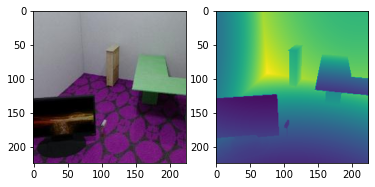

5146
/root/autodl-tmp/stage2/rgb-hm3d/train/1020147.jpg /root/autodl-tmp/stage2/depth-hm3d/train/1020147.png


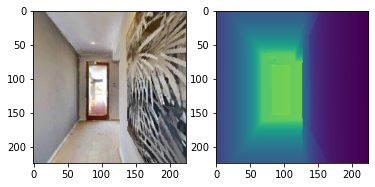

4116
/root/autodl-tmp/stage2/rgb-scenenet/train/1544522.jpg /root/autodl-tmp/stage2/depth-scenenet/train/1544522.png


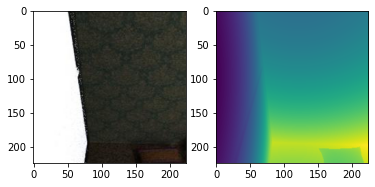

3744
/root/autodl-tmp/stage2/rgb-scenenet/train/2402489.jpg /root/autodl-tmp/stage2/depth-scenenet/train/2402489.png


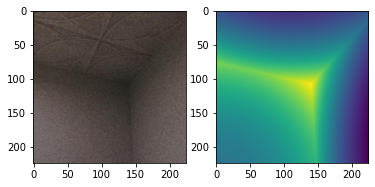

3869
/root/autodl-tmp/stage2/rgb-scenenet/train/393788.jpg /root/autodl-tmp/stage2/depth-scenenet/train/393788.png


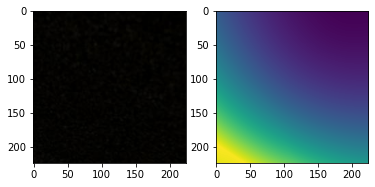

1545
/root/autodl-tmp/stage2/rgb-hm3d/train/437044.jpg /root/autodl-tmp/stage2/depth-hm3d/train/437044.png


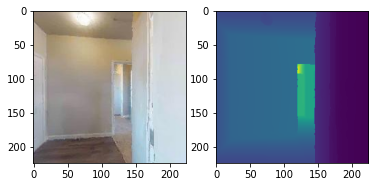

5651
/root/autodl-tmp/stage2/rgb-hm3d/train/2509430.jpg /root/autodl-tmp/stage2/depth-hm3d/train/2509430.png


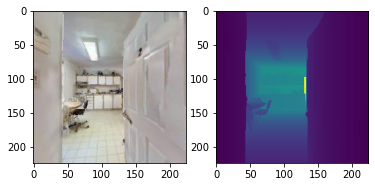

9203
/root/autodl-tmp/stage2/rgb-scenenet/train/1664007.jpg /root/autodl-tmp/stage2/depth-scenenet/train/1664007.png


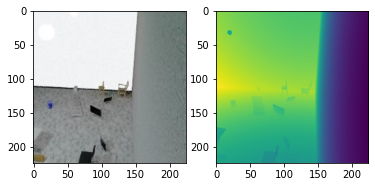

11671
/root/autodl-tmp/stage2/rgb-scenenet/train/2185104.jpg /root/autodl-tmp/stage2/depth-scenenet/train/2185104.png


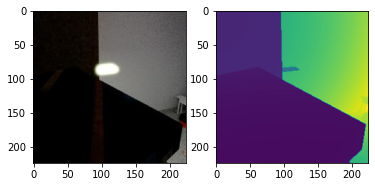

13199
/root/autodl-tmp/stage2/rgb-scenenet/train/1916098.jpg /root/autodl-tmp/stage2/depth-scenenet/train/1916098.png


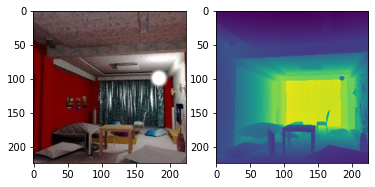

11801
/root/autodl-tmp/stage2/rgb-sun3d/train/77316.jpg /root/autodl-tmp/stage2/depth-sun3d/train/77316.png


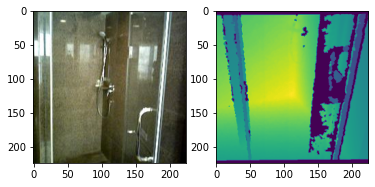

3239
/root/autodl-tmp/stage2/rgb-sun3d/train/396994.jpg /root/autodl-tmp/stage2/depth-sun3d/train/396994.png


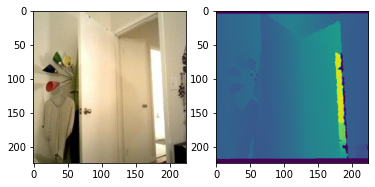

6138
/root/autodl-tmp/stage2/rgb-hm3d/train/397988.jpg /root/autodl-tmp/stage2/depth-hm3d/train/397988.png


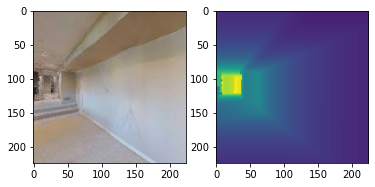

10000
/root/autodl-tmp/stage2/rgb-hm3d/train/1707188.jpg /root/autodl-tmp/stage2/depth-hm3d/train/1707188.png


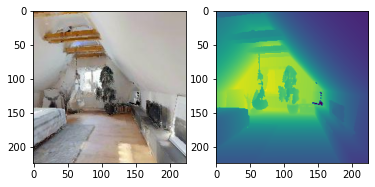

4757
/root/autodl-tmp/stage2/rgb-hm3d/train/393645.jpg /root/autodl-tmp/stage2/depth-hm3d/train/393645.png


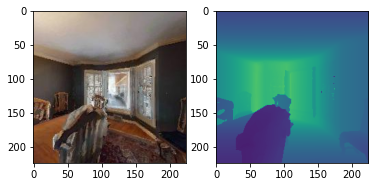

4974
/root/autodl-tmp/stage2/rgb-hm3d/train/2256028.jpg /root/autodl-tmp/stage2/depth-hm3d/train/2256028.png


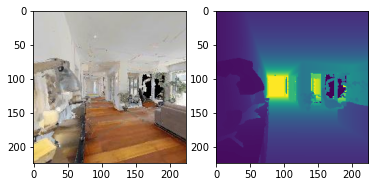

10000
/root/autodl-tmp/stage2/rgb-sun3d/train/1119265.jpg /root/autodl-tmp/stage2/depth-sun3d/train/1119265.png


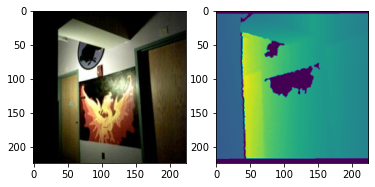

4846
/root/autodl-tmp/stage2/rgb-sun3d/train/1097188.jpg /root/autodl-tmp/stage2/depth-sun3d/train/1097188.png


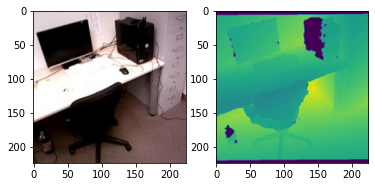

2756
/root/autodl-tmp/stage2/rgb-scenenet/train/2266778.jpg /root/autodl-tmp/stage2/depth-scenenet/train/2266778.png


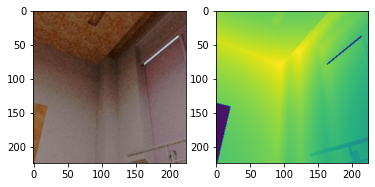

9546
/root/autodl-tmp/stage2/rgb-sun3d/train/2117120.jpg /root/autodl-tmp/stage2/depth-sun3d/train/2117120.png


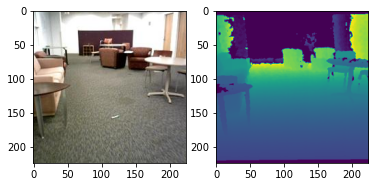

8191


In [164]:
# vision train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/train/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/train/*.png")))
assert len(rgb_files)==len(depth_files)
print(len(rgb_files))
for _ in range(20):
    idx = random.randint(0, len(rgb_files)-1)
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    plt.show()
    print(np.array(depth).max())

497100
/root/autodl-tmp/stage2/rgb-scenenet/val/134917.jpg /root/autodl-tmp/stage2/depth-scenenet/val/134917.png


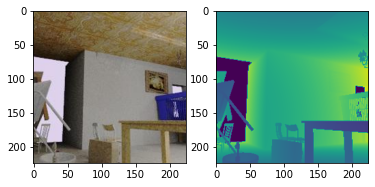

9346
/root/autodl-tmp/stage2/rgb-sun3d/val/111552.jpg /root/autodl-tmp/stage2/depth-sun3d/val/111552.png


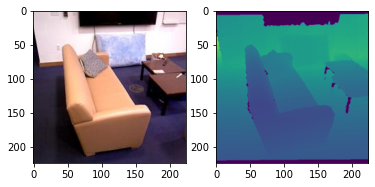

7286
/root/autodl-tmp/stage2/rgb-scenenet/val/147061.jpg /root/autodl-tmp/stage2/depth-scenenet/val/147061.png


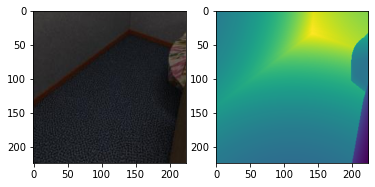

2584
/root/autodl-tmp/stage2/rgb-hm3d/val/1873.jpg /root/autodl-tmp/stage2/depth-hm3d/val/1873.png


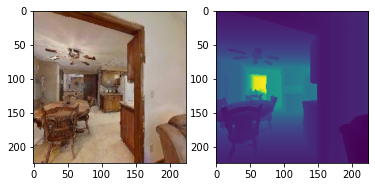

8739
/root/autodl-tmp/stage2/rgb-sun3d/val/120245.jpg /root/autodl-tmp/stage2/depth-sun3d/val/120245.png


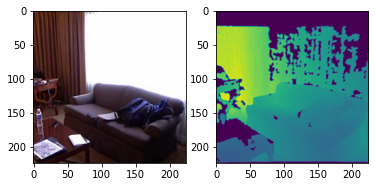

5202
/root/autodl-tmp/stage2/rgb-tum/val/8074.jpg /root/autodl-tmp/stage2/depth-tum/val/8074.png


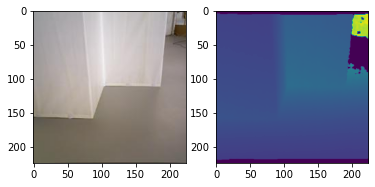

8399
/root/autodl-tmp/stage2/rgb-scenenet/val/88451.jpg /root/autodl-tmp/stage2/depth-scenenet/val/88451.png


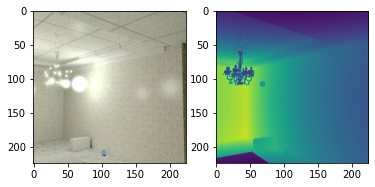

9053
/root/autodl-tmp/stage2/rgb-scenenet/val/82826.jpg /root/autodl-tmp/stage2/depth-scenenet/val/82826.png


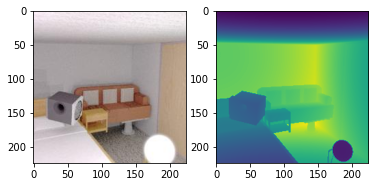

6917
/root/autodl-tmp/stage2/rgb-hm3d/val/151659.jpg /root/autodl-tmp/stage2/depth-hm3d/val/151659.png


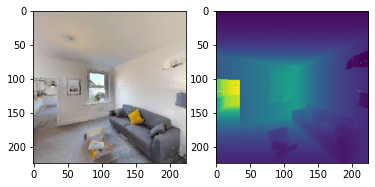

7395
/root/autodl-tmp/stage2/rgb-hm3d/val/66359.jpg /root/autodl-tmp/stage2/depth-hm3d/val/66359.png


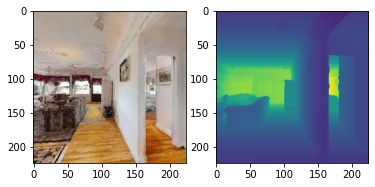

7840
/root/autodl-tmp/stage2/rgb-sun3d/val/21832.jpg /root/autodl-tmp/stage2/depth-sun3d/val/21832.png


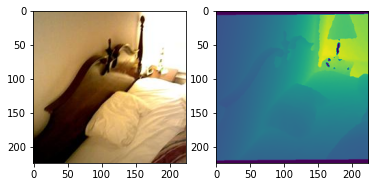

3241
/root/autodl-tmp/stage2/rgb-hm3d/val/5913.jpg /root/autodl-tmp/stage2/depth-hm3d/val/5913.png


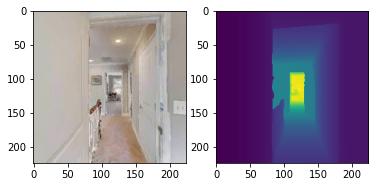

7784
/root/autodl-tmp/stage2/rgb-hm3d/val/46784.jpg /root/autodl-tmp/stage2/depth-hm3d/val/46784.png


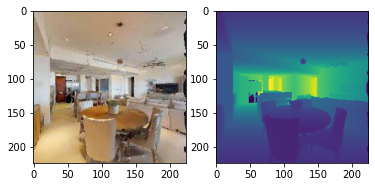

9589
/root/autodl-tmp/stage2/rgb-hm3d/val/2641.jpg /root/autodl-tmp/stage2/depth-hm3d/val/2641.png


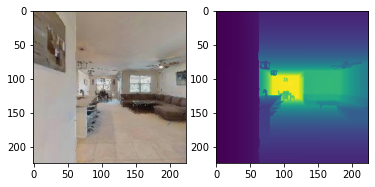

9602
/root/autodl-tmp/stage2/rgb-sun3d/val/13818.jpg /root/autodl-tmp/stage2/depth-sun3d/val/13818.png


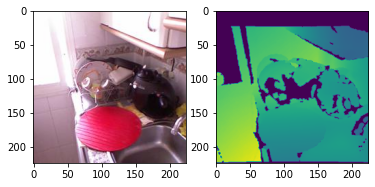

1744
/root/autodl-tmp/stage2/rgb-scenenet/val/137959.jpg /root/autodl-tmp/stage2/depth-scenenet/val/137959.png


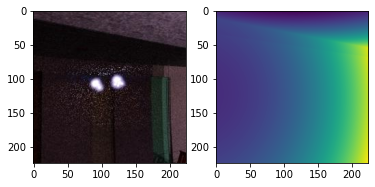

2237
/root/autodl-tmp/stage2/rgb-scenenet/val/127244.jpg /root/autodl-tmp/stage2/depth-scenenet/val/127244.png


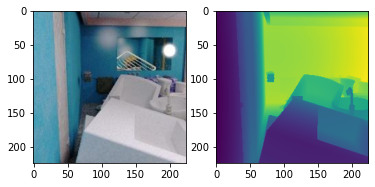

6399
/root/autodl-tmp/stage2/rgb-scenenet/val/79088.jpg /root/autodl-tmp/stage2/depth-scenenet/val/79088.png


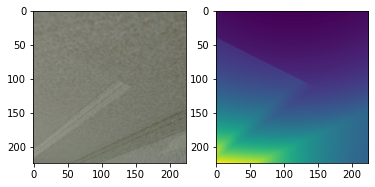

3580
/root/autodl-tmp/stage2/rgb-hm3d/val/152284.jpg /root/autodl-tmp/stage2/depth-hm3d/val/152284.png


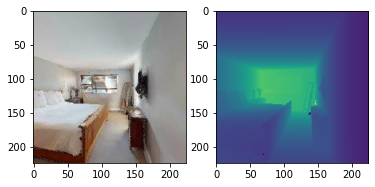

6896
/root/autodl-tmp/stage2/rgb-tum/val/10266.jpg /root/autodl-tmp/stage2/depth-tum/val/10266.png


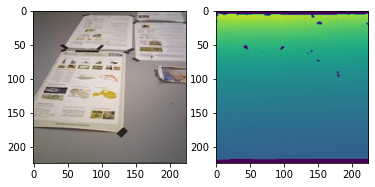

3701


In [152]:
# vision val
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/val/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/val/*.png")))
assert len(rgb_files)==len(depth_files)
print(len(rgb_files))
for _ in range(20):
    idx = random.randint(0, len(rgb_files)-1)
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    plt.show()
    print(np.array(depth).max())

In [155]:
# text train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/")
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-*/train/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-*/train/*.txt")))
assert len(text_files)==len(sub_files)
print(len(text_files))
for _ in range(20):
    idx = random.randint(0, len(text_files)-1)
    print("=========={}==========".format(idx))
    with open(text_files[idx], "r") as f:
        print("inst: "+f.read())
    with open(sub_files[idx], "r") as f:
        print("sub: "+f.read())

8180930
==========2359446==========
inst: Our delivery system at MixPixie is really simple. We Pixies work really closely with Mr Postman at Royal Mail to make sure that we get your order to you as soon as possible. Pixies are the best gift-givers, so we know just how important it is that your gift arrives on time. During the order process, MixPixie will notify you of the dispatch dates available and the expected time frame for receiving your order. We Pixies will also let you know of any delivery charges prior to the acceptance of your order. Some items are quicker to make than others, so there are different timescales for each item which may vary depending on the tie of year (at Christmas, for example!). If your order is urgent, as they can be sometimes, an express delivery option is available which will expedite your order to be shipped within 24 hours of your order being placed (often the same day). These express orders are sent tracked to b with you the next day.
sub: Our delivery

In [156]:
# text val
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/")
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-*/val/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-*/val/*.txt")))
assert len(text_files)==len(sub_files)
print(len(text_files))
for _ in range(20):
    idx = random.randint(0, len(text_files)-1)
    print("=========={}==========".format(idx))
    with open(text_files[idx], "r") as f:
        print("inst: "+f.read())
    with open(sub_files[idx], "r") as f:
        print("sub: "+f.read())

91591
==========46114==========
inst: Just looking at this Village-area place might give you cavities. The chocolate bar deals in all things cocoa, and does so with a sense of humor. Several varieties of chocolate in novelty shapes are available, as well as kitschy gift items, including doggie chocolates. The Texas Frito Brittle, a mix with chocolate, Fritos, pretzels and pecans - has been featured on the Food Network. The cake (expensive, but with slices big enough to share) and ice cream are particularly decadent.
sub: Just looking at this Village-area place might give you cavities.
The chocolate bar deals in all things cocoa, and does so with a sense of humor.
Several varieties of chocolate in novelty shapes are available, as well as kitschy gift items, including doggie chocolates.
The Texas Frito Brittle, a mix with chocolate, Fritos, pretzels and pecans - has been featured on the Food Network.
The cake (expensive, but with slices big enough to share) and ice cream are particularly

In [165]:
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage2/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage2/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/train/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/train/*.png")))
print(len(rgb_files), len(depth_files))

8180115 8180115


In [166]:
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage1/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage1/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/train/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/train/*.png")))
print(len(rgb_files), len(depth_files))

11833441 2331663


: 